# 12장: 텐서플로를 사용한 사용자 정의 모델과 훈련
- 132 - 156 (25 pages)

발표: TAVE 6기 [박제윤](https://jeiyoon.github.io/)

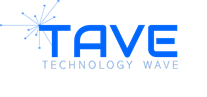

# [Note] 12장은 전체 42페이지. 그중에 12.3장은 25 페이지 (59.52\% 분량)

# ㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎㅎ😊😊😊😊😊😊😊😊😊😇

[목차]


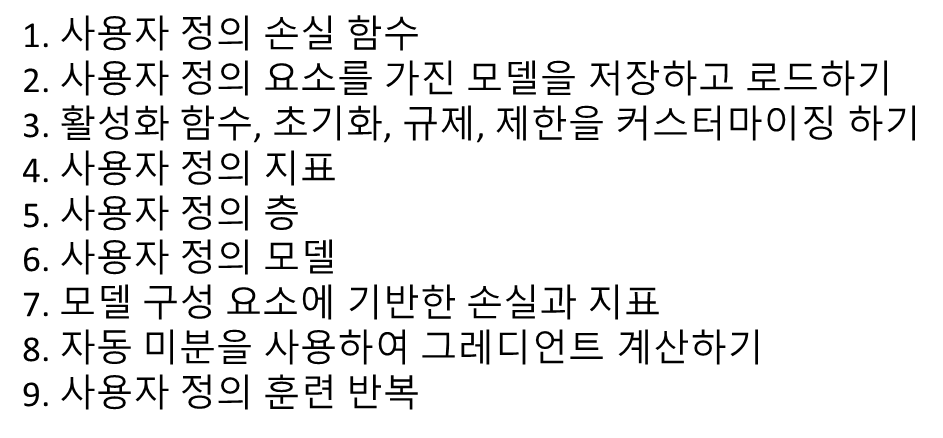

## 12.3.1 사용자 정의 손실 함수

In [26]:
# 데이터: california_housing
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

# 데이터 다 불러옴
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)

# train_full을 train, validation셋으로 분리
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

# 스케일러로 데이터 스케일을 변경
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [27]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.6.0


In [28]:
"""
MSE는 이상치에 관대해서 훈련이 수렴되기까지 시간이 걸림. 그리고 정확하지 않음

MSE 대신 후버 Huber 로스를 사용하면 좋음
"""

def huber_fn(y_true, y_pred):
  error = y_true - y_pred # 실제값 - 예측값
  is_small_error = tf.abs(error) < 1 # -1 < error < 1
  squared_loss = tf.square(error) / 2
  linear_loss = tf.abs(error) - 0.5

  # tf.where
  # tf.where(bool type 텐서, True일 때 출력값, False일 때 출력값)
  return tf.where(is_small_error, squared_loss, linear_loss)

### Huber loss?

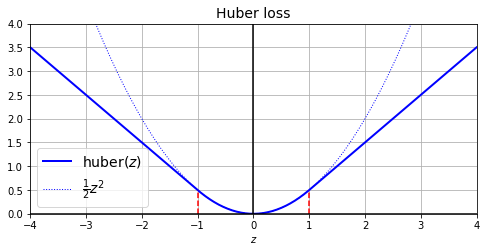

In [29]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [30]:
"""
Tensorflow 2.6.0
https://www.tensorflow.org/api_docs/python/tf/keras/losses/Huber

tf.keras.losses.Huber(
    delta=1.0, reduction=losses_utils.ReductionV2.AUTO, name='huber_loss'
)
"""
y_true = [[0, 1], [0, 0]]
y_pred = [[0.6, 0.4], [0.4, 0.6]]

h = tf.keras.losses.Huber()
print(h(y_true, y_pred).numpy())

0.155


In [31]:
# model.compile(loss = huber_fn, optimizer = "nadam")
# model.fit(X_train, y_train, [...])
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.6111 - mae: 0.9672 - val_loss: 0.2182 - val_mae: 0.5167
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2101 - mae: 0.5057 - val_loss: 0.1975 - val_mae: 0.4856


## 12.3.2 사용자 정의 요소를 가진 모델을 저장하고 로드하기

In [32]:
# 모델을 로드할때는 함수 이름과 실제 함수를 매핑한 딕셔너리를 전달해야함
model.save("my_model_with_a_custom_loss.h5")

model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2004 - mae: 0.4905 - val_loss: 0.1909 - val_mae: 0.4752
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.1961 - mae: 0.4835 - val_loss: 0.1862 - val_mae: 0.4673


In [36]:
# 매개변수를 받을 수 있는 함수
def create_huber(threshold = 1.0):
  def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < threshold
    squared_loss = tf.square(error) / 2
    linear_loss = threshold * tf.abs(error) - threshold ** 2 / 2

    return tf.where(is_small_error, squared_loss, linear_loss)

  return huber_fn

In [37]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])


model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

# save
model.save("my_model_with_a_custom_loss_threshold_2.h5")

# load
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2172 - mae: 0.4830 - val_loss: 0.2178 - val_mae: 0.4776
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2142 - mae: 0.4785 - val_loss: 0.2306 - val_mae: 0.4798
Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2116 - mae: 0.4751 - val_loss: 0.2122 - val_mae: 0.4650
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2090 - mae: 0.4720 - val_loss: 0.1967 - val_mae: 0.4587


In [45]:
# 모델을 저장할때 threshold 값은 저장되지 않음
# 따라서 모델을 로드할때 threshold 값을 지정해야함
# get_config() 메서드를 구현하여 해결할 수 있음

class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        # super?
        # https://velog.io/@gwkoo/%ED%81%B4%EB%9E%98%EC%8A%A4-%EC%83%81%EC%86%8D-%EB%B0%8F-super-%ED%95%A8%EC%88%98%EC%9D%98-%EC%97%AD%ED%95%A0
        
        # **kwargs ?
        # keyword argument의 줄임말
        # https://velog.io/@hj8853/Python-args%EC%99%80-kwargs
        """
        def name2(**kwargs):
          print(kwargs)
    
        name2(name1="홍길동",name2="이순신")
        
        >> {'name1': '홍길동', 'name2': '이순신'}
        """
        super().__init__(**kwargs)
    
    # 샘플의 손실을 반환
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        
        return tf.where(is_small_error, squared_loss, linear_loss)
    
    # 하이퍼파라미터 이름과 같이 매핑된 딕셔너리를 반환
    def get_config(self):
        base_config = super().get_config()
        # print({**base_config, "threshold": self.threshold})
        
        # {'reduction': 'auto', 'name': None, 'threshold': 2.0}
        # reduction algorithm?
        # http://sanghyukchun.github.io/60/
        # 손실함수의 name과 개별 샘플의 손실을 모으기 위해 사용할 reduction 알고리즘 (치환)
        return {**base_config, "threshold": self.threshold}

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

# 모델을 컴파일 할때, 클래스의 인스턴스 사용
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

# save
# 모델을 저장할때 임곗값도 함께 저장됨
model.save("my_model_with_a_custom_loss_class.h5")

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.9111 - mae: 1.0419 - val_loss: 0.3128 - val_mae: 0.5701
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2562 - mae: 0.5281 - val_loss: 0.2399 - val_mae: 0.5010
{'reduction': 'auto', 'name': None, 'threshold': 2.0}


In [46]:
# load
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})


model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

# model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])
print(model.loss.threshold)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2334 - mae: 0.5045 - val_loss: 0.2569 - val_mae: 0.5012
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2275 - mae: 0.4973 - val_loss: 0.2285 - val_mae: 0.4832
2.0


## 12.3.3 활성화 함수, 초기화 규제, 제한을 커스터마이징하기

In [52]:
# Resets all state generated by Keras.
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [53]:
"""
사용자 정의 활성화 함수
"""
def my_softplus(z): # tf.nn.softplus(z) 값을 반환합니다
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # tf.nn.relu(weights) 값을 반환합니다
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [54]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [55]:
# Resets all state generated by Keras.
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [56]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [57]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [58]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 1.4399 - val_mae: 0.5137


In [59]:
# save
model.save("my_model_with_many_custom_parts.h5")

# load
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

In [61]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    
    # __call__()
    # https://davi06000.tistory.com/10
    def __call__(self, weights):
        # my_l1_regularizer
        return tf.reduce_sum(tf.abs(self.factor * weights))
    
    def get_config(self):
        return {"factor": self.factor}

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

model.save("my_model_with_many_custom_parts.h5")

model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 1.5542 - mae: 0.8962 - val_loss: 1.4154 - val_mae: 0.5607
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.5943 - mae: 0.5256 - val_loss: 1.4399 - val_mae: 0.5137


## 12.3.4 사용자 정의 지표

- 손실과 지표는 개념적으로 다른 것은 아님

- 손실 (e.g. cross ent)은 모델을 훈련하기 위해 경사 하강법을 사용하므로 미분 가능해야함 (grad가 모든곳에서 0이 아니어야함, 사람이 쉽게 이해 못해도 됨)

- 지표는 모델을 평가할때 사용함. (훨씬 이해하기 쉬워야함, 미분 불가능 해도 됨, 그래디언트 0 이어도 됨)

### Precision

1) 

$$\frac{True Positives}{True Positives + False Negatives}$$

- True Positives: 모델이 참이라 했는데 실제로도 참 (맞음 -> True)
- False Negatives: 모델이 거짓이라 했는데 실제로는 참 (틀림 -> False)
- 즉, [맞음 or 틀림] [모델의 선택] ("틀림. 모델이 이렇게 했더니")

- e.g.) 그렇다면 True Negatives는?


2) Precision은 전체 정답의 개수 중에 모델이 맞춘 개수

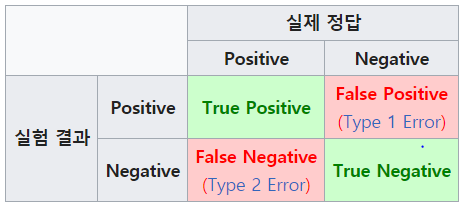

In [72]:
# 첫 batch: 5개 중에 4개 맞음 -> 80%
# 두번째 batch: 3개 중에 0개 맞음 -> 0%
# 그러면 정밀도는 40%? -> No

precision = keras.metrics.Precision()
# [0, 1, 1, 1, 0, 1, 0, 1], 
# [1, 1, 0, 1, 0, 1, 0, 1]
print(precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1]))

print(precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0]))

# result를 이용하면 현재 지표값을 얻을 수 있음
# precision은 배치마다 점진적으로 업데이트 되기 때문에 "스트리밍 지표 (streaming metric)라고 부름"
print(precision.result()) 
# 기록된 변수 확인
print("var: ", precision.variables)
# 변수를 초기화 (0으로)
precision.reset_states()

tf.Tensor(0.8, shape=(), dtype=float32)
tf.Tensor(0.5, shape=(), dtype=float32)
tf.Tensor(0.5, shape=(), dtype=float32)
var:  [<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>, <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]


In [79]:
# 스트리밍 지표 만드려면 keras.metrics.Metric 클래스를 상속함
# HuberMetric 유일한 이점: threshold 저장
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # 기본 매개변수 처리 (예를 들면, dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)

        # add_weight(): 여러 배치에 걸쳐 지표의 상태를 기록하기 위한 변수
        self.total = self.add_weight("total", initializer="zeros") 
        self.count = self.add_weight("count", initializer="zeros")
    
    # 배치의 레이블을 바탕으로 변수를 업데이트함
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred) # huber
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    
    # result: 최종 결과를 계산하고 반환함
    def result(self):
        return self.total / self.count
    
    # threshold 변수를 모델과 함께 저장
    def get_config(self):
        base_config = super().get_config()
        
        return {**base_config, "threshold": self.threshold}

m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
print(m(tf.constant([[2.]]), tf.constant([[10.]])))

# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

print(m.result())

print(m.variables)
m.reset_states()
print(m.variables)

# reset
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# model & save & load
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

model.save("my_model_with_a_custom_metric.h5")

model = keras.models.load_model("my_model_with_a_custom_metric.h5",
                                custom_objects={"huber_fn": create_huber(2.0),
                                                "HuberMetric": HuberMetric})

model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

print(model.metrics[-1].threshold)

tf.Tensor(14.0, shape=(), dtype=float32)
tf.Tensor(7.0, shape=(), dtype=float32)
[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>, <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]
[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]
Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.8707 - huber_metric: 0.8707
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.2595 - huber_metric: 0.2595
Epoch 1/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2350 - huber_metric: 0.2350
Epoch 2/2
363/363 [==============================] - 1s 1ms/step - loss: 0.2278 - huber_metric: 0.2278
2.0


## 12.3.5 사용자 정의 층

### 예를들면 언제 쓸까?: 층 B층 C층 반복 (ABCABCABC) -> ABC = D -> (DDD)

In [80]:
# keras.layers.Flatten이나 keras.layers.ReLU 같은 층은 가중치가 없음
# 이런층들을 lambda로 감쌀 수 있음
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))
exponential_layer([-1., 0., 1.])

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/5
363/363 [==============================] - 1s 2ms/step - loss: 1.0631 - val_loss: 0.4457
Epoch 2/5
363/363 [==============================] - 1s 1ms/step - loss: 0.4562 - val_loss: 0.3798
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4029 - val_loss: 0.3548
Epoch 4/5
363/363 [==============================] - 1s 1ms/step - loss: 0.3851 - val_loss: 0.3464
Epoch 5/5
162/162 [==============================] - 0s 1ms/step - loss: 0.3586


0.3586341142654419

In [84]:
# keras Dense층을 간소화한 버전 (사용자 커스터마이징)
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    # build의 역할
    # 가중치마다 add_weight() 매서드를 호출하여 층의 변수를 만드는 것
    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        
        super().build(batch_input_shape) # must be at the end

    # 이 층에서 필요한 연산을 수행
    def call(self, X):
        # @: at operator
        # 행렬곱을 할때 사용됨
        """
        import numpy

        x = numpy.ones(3) # array([1., 1., 1.])
        y = numpy.ones(3) # array([1., 1., 1.])
        z = x @ y

        print(z) // 3
        """
        # 여기선 입력 X와 층의 커널의 행렬곱을 하기위해 사용됨
        return self.activation(X @ self.kernel + self.bias)

    # 이 층의 출력 크기를 반환함
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        
        # keras.activations.serialize(): 활성화 함수의 전체 설정을 저장
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}


keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])


model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

model.save("my_model_with_a_custom_layer.h5")


model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 2.2563 - val_loss: 0.9472
Epoch 2/2
162/162 [==============================] - 0s 1ms/step - loss: 0.5474


In [89]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        # call() 메서드는 심볼릭 입력을 받음 
        # 이 입력의 크기는 부분적으로만 지정되어 있음
        # 이 시점에서는 배치 크기를 모름 
        # 그래서 첫 번째 차원이 None임
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape) # 사용자 정의 층 디버깅
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]


inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

X1.shape:  (None, 2)  X2.shape:  (None, 2)


In [91]:
def split_data(data):
    columns_count = data.shape[-1]
    half = columns_count // 2
    return data[:, :half], data[:, half:]

# 사용자 층에 실제 데이터를 전달할 수도 있음
X_train_scaled_A, X_train_scaled_B = split_data(X_train_scaled)
X_valid_scaled_A, X_valid_scaled_B = split_data(X_valid_scaled)
X_test_scaled_A, X_test_scaled_B = split_data(X_test_scaled)

# 분할된 데이터 크기 출력
X_train_scaled_A.shape, X_train_scaled_B.shape

outputs1, outputs2 = MyMultiLayer()((X_train_scaled_A, X_train_scaled_B))

# reset
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

input_A = keras.layers.Input(shape=X_train_scaled_A.shape[-1])
input_B = keras.layers.Input(shape=X_train_scaled_B.shape[-1])

# MyMultiLayer
hidden_A, hidden_B = MyMultiLayer()((input_A, input_B))
hidden_A = keras.layers.Dense(30, activation='selu')(hidden_A)
hidden_B = keras.layers.Dense(30, activation='selu')(hidden_B)
concat = keras.layers.Concatenate()((hidden_A, hidden_B))
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

model.compile(loss='mse', optimizer='nadam')

model.fit((X_train_scaled_A, X_train_scaled_B), y_train, epochs=2,
          validation_data=((X_valid_scaled_A, X_valid_scaled_B), y_valid))

X1.shape:  (11610, 4)  X2.shape:  (11610, 4)
X1.shape:  (None, 4)  X2.shape:  (None, 4)
Epoch 1/2
X1.shape:  (None, 4)  X2.shape:  (None, 4)
X1.shape:  (None, 4)  X2.shape:  (None, 4)
363/363 [==============================] - 2s 2ms/step - loss: 2.1142 - val_loss: 1.3630
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.9684 - val_loss: 0.9773


In [92]:
# 훈련하는 동안 규제 목적으로 가우스 잡음을 추가하고
# 테스트 시에넌 아무것도 하지 않는 층
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape


keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# model
model = keras.models.Sequential([
    AddGaussianNoise(stddev=1.0),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 1s 2ms/step - loss: 2.3857 - val_loss: 7.6082
Epoch 2/2
162/162 [==============================] - 0s 1ms/step - loss: 0.7560


0.7559615969657898

## 12.3.6 사용자 정의 모델

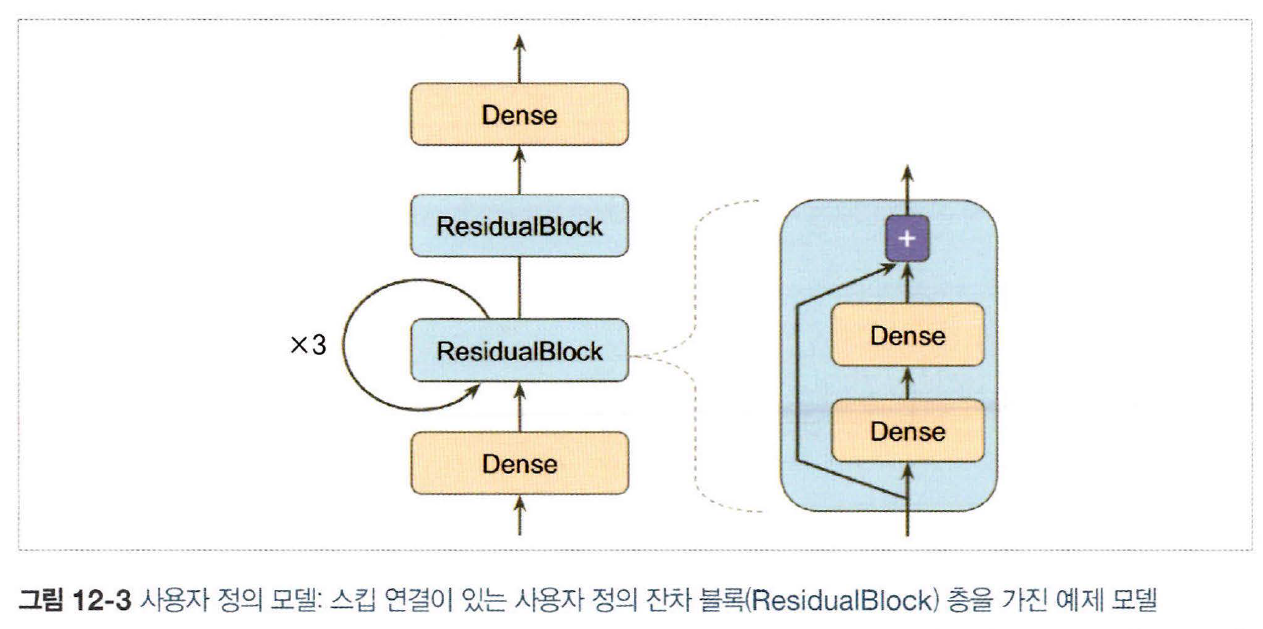

In [93]:
X_new_scaled = X_test_scaled

In [95]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu", # (exponential linear unit)
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z # residual


# 서브클래싱 API를 사용해 이 모델을 정의해봅시다.
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu", # (exponential linear unit)
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)


keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")

# model.fit 사용 가능 
history = model.fit(X_train_scaled, y_train, epochs=5)

# model.evaluate 사용 가능
score = model.evaluate(X_test_scaled, y_test)

# model.predict 사용 가능
y_pred = model.predict(X_new_scaled)

Epoch 1/5
363/363 [==============================] - 2s 2ms/step - loss: 9.1325
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 1.0579
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.8869
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.5832
Epoch 5/5
162/162 [==============================] - 0s 1ms/step - loss: 0.6511


### 12.3.7 모델 구성 요소에 기반한 손실과 지표

In [96]:
# 모델 구성요소?
# e.g.) 가중치, 활성함수

# 다섯개의 은닉층과 출력층으로 구성된 회귀용 MLP
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruct = keras.layers.Dense(8) # TF 이슈 #46858에 대한 대책
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")
        """
        [Disclaimer]
          TF 2.2에 있는 이슈(#46858) 때문에 build() 메서드와 함께 add_loss()를 사용할 수 없습니다. 
          따라서 다음 코드는 책과 다릅니다. build() 메서드 대신 생성자에 reconstruct 층을 만듭니다. 
          이 때문에 이 층의 유닛 개수를 하드코딩해야 합니다(또는 생성자 매개변수로 전달해야 합니다).
        """      
#     TF 이슈 #46858 때문에 주석 처리
#     def build(self, batch_input_shape):
#         n_inputs = batch_input_shape[-1]
#         self.reconstruct = keras.layers.Dense(n_inputs, name='recon')
#         super().build(batch_input_shape)

    # 입력이 다섯개의 은닉층을 모두 통과함
    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        self.recon_loss = 0.05 * tf.reduce_mean(tf.square(reconstruction - inputs))
        
        if training:
           result = self.reconstruction_mean(recon_loss)
           self.add_metric(result)
        return self.out(Z)
    
    """
    CHECK THIS OUT
    """
    def train_step(self, data):
        x, y = data

        # tf.GradientTape() ?
        # https://www.tensorflow.org/guide/autodiff?hl=ko
        # 컨텍스트(context) 안에서 실행된 모든 연산을 테이프(tape)에 "기록"합니다. 
        with tf.GradientTape() as tape:
            y_pred = self(x)
            # recon_loss
            loss = self.compiled_loss(y, y_pred, regularization_losses=[self.recon_loss])

        # tape.gradient
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {m.name: m.result() for m in self.metrics}

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

Epoch 1/2
363/363 [==============================] - 2s 2ms/step - loss: 0.7885 - reconstruction_error: 0.0000e+00
Epoch 2/2
363/363 [==============================] - 1s 2ms/step - loss: 0.4126 - reconstruction_error: 0.0000e+00


## 12.3.8 자동 미분을 사용하여 그레이디언트 계산하기

In [100]:
def f(w1, w2):
    # 3x^2 + 2x + a -> 6x + 2
    return 3 * w1 ** 2 + 2 * w1 * w2


w1, w2 = 5, 3
eps = 1e-6

# 미분계수 공식
print((f(w1 + eps, w2) - f(w1, w2)) / eps)

print((f(w1, w2 + eps) - f(w1, w2)) / eps)


w1, w2 = tf.Variable(5.), tf.Variable(3.)

# 변수와 관련된 모든 연산을 자동으로 기록
with tf.GradientTape() as tape:
    z = f(w1, w2)

# gradient()가 호출된 후에는 자동으로 테이프가 즉시 지워짐
# 그래서 tape.gradient()를 동시에 두번 호출하면 에러가 남
gradients = tape.gradient(z, [w1, w2])
print(gradients)

# 만약에 gradient를 두번 이상 호출하려면 지속가능한 tape를 호출하고 사용이 끝나면 삭제해야됨
"""
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!
del tape
"""

36.000003007075065
10.000000003174137
[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>, <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]


In [102]:
# 기본적으로 tape는 변수가 포함된 연산만을 기록함
# 그래서 변수가 아닌 다른 객체에 대한 그레이디언트를 계산하면 None이 나옴
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
print(gradients)

# 필요하면 모든 연산을 기록하도록 강제할 수 있음
# 사용처: 입력이 작을때 변동폭이 큰 활성화 함수에 대한 규제손실을 구현할때 사용 가능
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
print(gradients)

[None, None]
[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>, <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]


In [103]:
# "아~ 이런게 있구나"
# 후진 모드 자동 미분 (reverse-moel autodiff)이 적합함
# 한번에 정방향 계산과 역방향 계산으로 모든 그레이디언트를 동시에 계산할 수 있기 때문.
# 예를들어 모델 파라미터에 대한 각 손실의 그레이디언트를 개별적으로 계산하고 싶다면 tape의 jacobian() 매서드를 호출해야함

# jacobian() 
# 벡터에 있는 각 손실마다 후진 자동 미분을 수행함
# 이계도함수도 가능 (Hessian)
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [105]:
with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)
del tape

In [106]:
with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [107]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [108]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

In [110]:
# 신경망의 일부분에 그레이디언트가 역전파되지 않도록 막아야할 때
def f(w1, w2):
    # stop_gradient
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])
print(gradients) # Note: None

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]


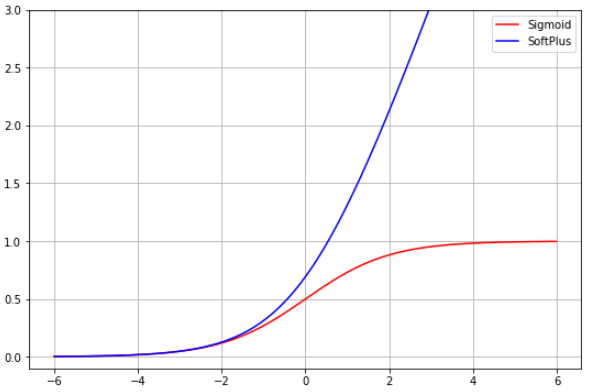

In [111]:
# 그레이디언트의 수치적인 이슈
# e.g.) 큰 입력에 대한 my_softplus() -> NaN

x = tf.Variable(100.)
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=nan>]

In [114]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    # 여전히 지수이기 때문에 값이 폭주하긴 함
    return tf.math.log(exp + 1), my_softplus_gradients

# 해결방법: tf.where()을 사용해 값이 클 때 입력을 그대로 반환하는 것입니다.
"""
주석 풀어보기
"""
# def my_better_softplus(z):
#     return tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))    

x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

print(z, tape.gradient(z, [x]))

tf.Tensor([inf], shape=(1,), dtype=float32) [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>]


## 12.3.9 사용자 정희 훈련 반복

In [115]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [117]:
# 앞에서 봤던 간단한 모델
l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

# 훈련 세트에서 샘플 배치를 랜덤하게 추출하는 작은 함수
# 13장에서 더 좋은방법 소개해준다고함
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

# 현재 스텝수, 전체 스탭 횟수, 에포크 시작부터 평균손실
# 그 외 다른 지표를 포함하여 훈련 상태를 출력하는 함수도 만듦
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics,
          end=end)

In [120]:
# 옵션
import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)


progress_bar(3500, 10000, size=6)


def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)


mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000
50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


In [122]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# 하이퍼 파라미터
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [123]:
# 학습
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
11610/11610 [==============================] - mean: 1.3955 - mean_absolute_error: 0.5722
Epoch 2/5
11610/11610 [==============================] - mean: 0.6774 - mean_absolute_error: 0.5280
Epoch 3/5
11610/11610 [==============================] - mean: 0.6351 - mean_absolute_error: 0.5177
Epoch 4/5
11610/11610 [==============================] - mean: 0.6384 - mean_absolute_error: 0.5181
Epoch 5/5
11610/11610 [==============================] - mean: 0.6440 - mean_absolute_error: 0.5222


In [124]:
try:
    from tqdm.notebook import trange
    from collections import OrderedDict
    with trange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps:
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))                    
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_states()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/362 [00:00<?, ?it/s]